In [1]:
%matplotlib inline

In [ ]:
from nb_import_exp import *

# abstract

Follows what I have been trying.

- run t-SNE on dataset usually employ with t-SNE
- run force on same datasets
- develop a verified version of force in Python
- explore different types of initialisation for t-SNE

# number of neighbhour of same class in K-ANN

# influence of different initialisation

# comparison stress for t-SNE and force embeddings

# t-SNE gradient

The gradient of the cost is equal to:


$$\frac{\partial C}{\partial y_i} = 4 \sum_j (p_{ij} - q_{ij})(y_i - y_j)(1+\lVert y_i - y_j \rVert^2)^{-1}$$


which for one point $i$ takes into account the influence of all other points $j$. The shape of the gradient can be explored by looking at the contribution of 1 point to its norm:

$$\lVert \frac{\partial C_j}{\partial y_i} \rVert = \lVert (p_{ij} - q_{ij})(y_i - y_j)(1+\lVert y_i - y_j \rVert^2)^{-1} \rVert$$

If we set the two variables $x = \lVert x_i - x_j \rVert$ and $y = \lVert y_i - y_j \rVert$, we get:


$\lVert \frac{\partial C_j}{\partial y_i} \rVert = 4 \lVert F_{attr,i} - F_{rep,i} \rVert$

$F_{attr,i} = Z * p_{ij}q_{ij} Z (y_i-y_j)$

$F_{rep,i} = Z * q_{ij}^2 (y_i-y_j)$

$Z = \sum_{k \neq l} (1+ \lVert y_k - y_l \rVert^2)^{-1}$

$p_{i|j} = \frac{exp(-\lVert x_i - x_j \rVert^2/2\sigma_i^2)}{\sum_{k \neq i} exp(-\lVert x_i - x_k \rVert^2/2\sigma_i^2)}$


$p_{ij} = \frac{p_{i|j} + p_{j|i}}{2N}$

$q_{ij} = \frac{(1 + \lVert y_i - y_j \rVert^2)^{-1}}{\sum_{k \neq l} (1 + \lVert y_k - y_l \rVert^2)^{-1}}$



$p_{ij} = C_0 exp(-x^2/C_1)$

$q_{ij} = D_0 (1 + y^2)^{-1}$


$$\lVert \frac{\partial C_j}{\partial y_i} \rVert = (C_0 exp(-x^2/C_1) - D_0 (1 + y^2)^{-1}) \frac{y}{1+y^2}$$

$$\lVert \frac{\partial C_j}{\partial y_i} \rVert = \frac{C_0 y \exp(-x^2/C_1)}{1+y^2} - \frac{D_0 y}{(1+y^2)^2}$$

<font size="5">
Test
</font>


In [107]:
C0 = 1
C1 = 1
D0 = 1

def gradient(x, y):
    A = C0 * y * np.exp(-x**2/C1) / (1+y**2)
    B = D0 * y / (1+y**2)**2
    
    return A - B

In [108]:
N = 50
x = np.linspace(0,10,N)
y = np.linspace(0,10,N)
X,Y = np.meshgrid(x, y) # grid of point

In [109]:
Z = gradient(X, Y) # evaluation of the function on the grid

In [110]:
# plt.imshow(Z)

In [111]:
from matplotlib import cm

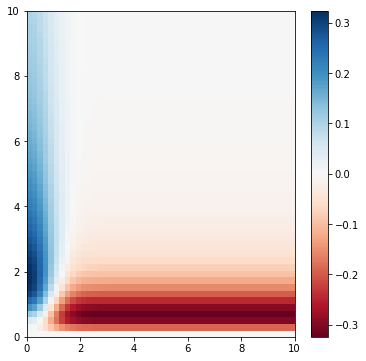

In [112]:
fig, ax = plt.subplots(figsize=(6,6))
res = ax.pcolor(x, y, Z, cmap=cm.RdBu)
fig.colorbar(res, ax=ax)

In [99]:
from ipywidgets import interactive, IntSlider

In [115]:
def plot_gradient(a, b, c, N):
    
    C0 = a
    C1 = b
    D0 = c

    def gradient(x, y):
        A = C0 * y * np.exp(-x**2/C1) / (1+y**2)
        B = D0 * y / (1+y**2)**2
        return A - B

    N = N
    x = np.linspace(0,10,N)
    y = np.linspace(0,10,N)
    X,Y = np.meshgrid(x, y) # grid of point

    Z = gradient(X, Y) # evaluation of the function on the grid
    
    fig, ax = plt.subplots(figsize=(6,6))
    res = ax.pcolor(x, y, Z, cmap=cm.RdBu)
    fig.colorbar(res, ax=ax)

In [122]:
w = interactive(plot_gradient, a=IntSlider(1,1,10), b=IntSlider(1,1,10), c=IntSlider(1,1,10), 
                N=IntSlider(30,10,100), continuous_update=False)

In [123]:
display(w)

interactive(children=(IntSlider(value=1, description='a', max=10, min=1), IntSlider(value=1, description='b', …